# Clustering Task


In [1]:
import scanpy as sc
from sklearn.metrics import adjusted_rand_score, v_measure_score
from sklearn.model_selection import train_test_split
import scanpy.external as sce

# reproducibility
seed = 999

/Users/mikael/miniconda3/envs/ml4g-proj-2/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/mikael/miniconda3/envs/ml4g-proj-2/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/mikael/miniconda3/envs/ml4g-proj-2/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/mikael/miniconda3/envs/ml4g-proj-2/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/Users/mikael/miniconda3/envs/ml4g-proj-2/lib/python3.10/site-packages/anndata

In [2]:
# split training data to prevent leakage (since patient 7 two samples)

# Load training data
train_adata_path = '../data/cluster/train/train_adata.h5ad'
train_adata = sc.read_h5ad(train_adata_path)

# List of unique patients
patients = train_adata.obs['Patient'].unique()
print("Patients in training data:", patients)

# Split patients into training and validation sets
train_patients, val_patients = train_test_split(
    patients, test_size=0.3, random_state=seed
)

# Subset the data
train_subset = train_adata[train_adata.obs['Patient'].isin(train_patients)].copy()
validation_subset = train_adata[train_adata.obs['Patient'].isin(val_patients)].copy()

print("Training patients:", train_patients)
print("Validation patients:", val_patients)

Patients in training data: ['P1', 'P2', 'P3', 'P4', 'P7']
Categories (5, object): ['P1', 'P2', 'P3', 'P4', 'P7']
Training patients: ['P2', 'P7', 'P1']
Categories (5, object): ['P1', 'P2', 'P3', 'P4', 'P7']
Validation patients: ['P4', 'P3']
Categories (5, object): ['P1', 'P2', 'P3', 'P4', 'P7']


In [3]:
# Combine training and validation subsets to ensure consistent preprocessing and batch correction
combined_train_adata = train_subset.concatenate(
    validation_subset,
    batch_key='validation_split',
    batch_categories=['train', 'validation'],
    index_unique=None
)

/var/folders/tp/l4sw2ybd7t3b9gbsrzngsn6w0000gn/T/ipykernel_42893/3985071899.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_train_adata = train_subset.concatenate(


In [4]:
# preprocess combined data
# - Mitochondrial gene expression is used as a quality metric because high levels may indicate cell stress or death
# - Cells with high mitochondrial content (>5%) are filtered out
# - Cells with extremely high total counts or gene numbers are also filtered to remove potential doublets (two cells captured as one)
# - Normalization adjusts for differences in sequencing depth across cells by scaling each cell's total counts to a common value (10,000)
# - Log Transformation stabilizes the variance across genes, making the data more suitable for downstream analysis


# quality control

# Don't need to identify mt genes as already done for us

# Identify mitochondrial genes
# combined_train_adata.var['mt'] = combined_train_adata.var_names.str.startswith('MT-')

# Calculate QC metrics
# sc.pp.calculate_qc_metrics(
#     combined_train_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True
# )

# Filter cells
combined_train_adata = combined_train_adata[combined_train_adata.obs.pct_counts_mt < 5, :]
sc.pp.filter_cells(combined_train_adata, max_counts=25000)
sc.pp.filter_cells(combined_train_adata, max_genes=6000)


# Normalization and Log Transformation

# Normalize total counts per cell
sc.pp.normalize_total(combined_train_adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(combined_train_adata)


# Highly Variable Genes (HVGs)

# Identify Highly Variable Genes (HVGs) using Seurat's method while accounting for batch effects
# NOTE: Highly Variable Genes are selected because they provide the most information for distinguishing between different cell types


# Identify HVGs
sc.pp.highly_variable_genes(
    combined_train_adata,
    flavor='seurat_v3',
    n_top_genes=2000,
    batch_key='Sample'
)

# Subset to HVGs
combined_train_adata = combined_train_adata[:, combined_train_adata.var.highly_variable]


# Scaling and PCA
# Perform PCA to reduce dimensionality
# WHY?: PCA simplifies scRNA-seq data by extracting key components, improving signal-to-noise ratio, 
# enabling effective batch correction and focusing clustering on biologically meaningful differences
# leading to more robustness of insights


# Scale the data
sc.pp.scale(combined_train_adata, max_value=10)

# Perform PCA
sc.tl.pca(combined_train_adata, svd_solver='arpack', n_comps=200)


# Batch Correction with Harmony
# NOTE: Harmony adjusts for batch effects in the PCA embeddings, preserving biological variability

# Run Harmony integration on PCA embeddings
sce.pp.harmony_integrate(combined_train_adata, key='Sample')

/Users/mikael/miniconda3/envs/ml4g-proj-2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:165: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number
/Users/mikael/miniconda3/envs/ml4g-proj-2/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/Users/mikael/miniconda3/envs/ml4g-proj-2/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2024-12-04 09:31:24,672 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-04 09:31:54,803 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-04 09:31:55,065 - harmonypy - INFO - Iteration 1 of 10
2024-12-04 09:32:40,579 - harmonypy - INFO - Iteration 2 of 10
2024-12-04 09:32:45,909 - harmonypy

In [5]:
# Clustering on combined data
# - A k-Nearest Neighbors (KNN) graph is constructed using the Harmony-corrected PCA embeddings
# - graph represents the similarity between cells based on their gene expression profiles
# - Leiden Clustering detects communities (clusters) in the KNN graph


# Compute neighborhood graph
sc.pp.neighbors(combined_train_adata, n_neighbors=30, use_rep='X_pca_harmony')

# Cluster using Leiden algorithm
sc.tl.leiden(combined_train_adata, resolution=0.2)

/Users/mikael/miniconda3/envs/ml4g-proj-2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/tp/l4sw2ybd7t3b9gbsrzngsn6w0000gn/T/ipykernel_42893/2545679082.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(combined_train_adata, resolution=0.2)


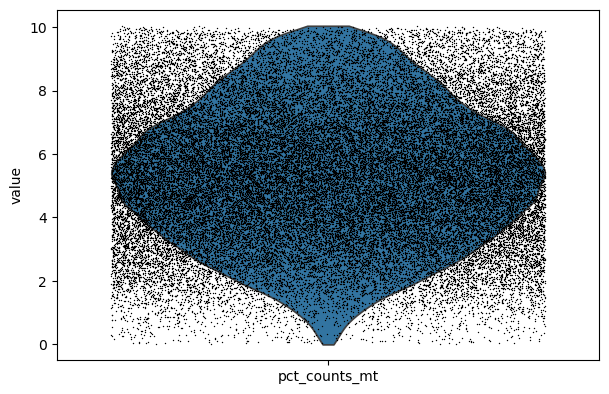

In [ ]:
#import matplotlib.pyplot as plt
# print(combined_train_adata.X.data.mean())
# print(combined_train_adata.X.data.std())
# print(combined_train_adata.X.data.max())
# print(combined_train_adata.X.data.min())
# plt.hist(np.log(combined_train_adata.X.data), bins=100)  # Histogram of values
# plt.title('Histogram of transformed data')
# plt.show()
# print(combined_train_adata)
# sc.tl.umap(combined_train_adata)
# sc.pl.umap(combined_train_adata, color='leiden')
sc.pl.violin(combined_train_adata, ['pct_counts_mt'], jitter=0.4)

In [3]:
# Evaluate Clustering Performance on Validation Set

# Split combined data back
train_indices = combined_train_adata.obs['validation_split'] == 'train'
val_indices = combined_train_adata.obs['validation_split'] == 'validation'

train_subset = combined_train_adata[train_indices].copy()
validation_subset = combined_train_adata[val_indices].copy()


# eval cluster performance

# True labels and predicted clusters for validation data
true_labels = validation_subset.obs['highLevelType']
pred_labels = validation_subset.obs['leiden']

# Compute ARI
ari = adjusted_rand_score(true_labels, pred_labels)
print(f"Validation Adjusted Rand Index (ARI): {ari:.4f}")

# Compute V-measure
v_measure = v_measure_score(true_labels, pred_labels)
print(f"Validation V-measure Score: {v_measure:.4f}")

# Combined metric
clustering_score = 0.5 * v_measure + 0.5 * ari
print(f"Validation Clustering Score: {clustering_score:.4f}")

NameError: name 'combined_train_adata' is not defined

In [4]:
# PROCEED WITH TEST DATA CLUSTERING


# Load test data
test_adata_path = '../data/cluster/test/test_adata.h5ad'
test_adata = sc.read_h5ad(test_adata_path)

# Filter training data before combining
train_adata_filtered = train_adata.copy()

# Quality control for training data only
train_adata_filtered = train_adata_filtered[train_adata_filtered.obs.pct_counts_mt < 5, :]
sc.pp.filter_cells(train_adata_filtered, max_counts=25000)
sc.pp.filter_cells(train_adata_filtered, max_genes=6000)

# Combine filtered training data with test data (unfiltered)
combined_adata = train_adata_filtered.concatenate(
    test_adata,
    batch_key='dataset',
    batch_categories=['train', 'test'],
    index_unique=None
)

# Normalization and log transformation
sc.pp.normalize_total(combined_adata, target_sum=1e4)
sc.pp.log1p(combined_adata)

# HVGs
sc.pp.highly_variable_genes(
    combined_adata,
    flavor='seurat_v3',
    n_top_genes=2000,
    batch_key='Sample'
)
combined_adata = combined_adata[:, combined_adata.var.highly_variable]

# Scaling and PCA
sc.pp.scale(combined_adata, max_value=10)
sc.tl.pca(combined_adata, svd_solver='arpack', n_comps=200)

# Harmony integration
sce.pp.harmony_integrate(combined_adata, key='Sample')

# Clustering
sc.pp.neighbors(combined_adata, n_neighbors=30, use_rep='X_pca_harmony')
sc.tl.leiden(combined_adata, resolution=0.2)

/Users/mikael/miniconda3/envs/ml4g-proj-2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:165: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number
/var/folders/tp/l4sw2ybd7t3b9gbsrzngsn6w0000gn/T/ipykernel_43672/3778728781.py:17: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = train_adata_filtered.concatenate(
/Users/mikael/miniconda3/envs/ml4g-proj-2/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/Users/mikael/miniconda3/envs/ml4g-proj-2/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  v

In [13]:
# Extract test data from combined AnnData object
test_data = combined_adata[combined_adata.obs['dataset'] == 'test']

# Adjust clusters to 1-based indexing
test_clusters_df = test_data.obs[['leiden']].reset_index()
test_clusters_df.columns = ['index', 'cluster']  # Rename the original index column for clarity

# Convert categorical clusters to integers, adjust, and revert to categorical
test_clusters_df['cluster'] = (
    test_clusters_df['cluster'].astype(int) + 1
)

In [6]:
# sanity checks
assert all(test_clusters_df.columns == ["index", "cluster"]), "Wrong columns"
assert all(test_clusters_df["index"] == test_adata.obs_names), "The cell ids are either not all present or not in the right order"

In [14]:
# Save the result to a CSV file
output_path = '../submission/cluster_membership.csv'
test_clusters_df.to_csv(output_path, index=True)
print(f"File saved to: {output_path}")

File saved to: ../submission/cluster_membership.csv
